In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [2]:

# from model import load_model
# from explanation_models import gradcam
# test=load_model('inceptionv3')
# model=test.model
# input_dim=test.input_dim
# layer_name='conv2d_93'
# g= gradcam(model,layer_name,input_dim)

In [3]:
train_captions=np.load('captioning/train_captions.npy')

In [4]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [5]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [6]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [7]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [8]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [9]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [10]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [11]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

## Model  ( Ref : tensorflow tutorial )

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [12]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [13]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [14]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [15]:
embedding_dim = 256
units = 512
top_k = 5000
attention_features_shape = 64
vocab_size = top_k + 1
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [16]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [17]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [18]:

def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    with tf.GradientTape() as tape:
        img_tensor_val = image_features_extract_model(temp_input) # cnn model
        img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3])) #reshape `

        features = encoder(img_tensor_val)

        dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
        result = []

        for i in range(max_length):

            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            # print(predictions.shape)
            # print(np.argmax(predictions))
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

            predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
            
            result.append(tokenizer.index_word[predicted_id])

            if tokenizer.index_word[predicted_id] == '<end>':
                return result, attention_plot

            dec_input = tf.expand_dims([predicted_id], 0)

    gradients=tape.gradient(predictions, img_tensor_val)
   

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,gradients

In [19]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## Try it on your own images
For fun, below we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


In [20]:
def load_test_img(img_path=None):
    from tensorflow import keras
    img = keras.preprocessing.image.load_img(img_path, target_size=(299, 299))
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    preprocess_input =keras.applications.inception_v3.preprocess_input
    # decode_predictions = keras.applications.vgg16.decode_predictions
    preprocessed_input=preprocess_input(array)
    return img,preprocessed_input
    
def evaluate_with_gradcam(image):

    return result, attention_plot,gradients

Prediction Caption: distant cases map wades tent london empty factory energy beagle fifteen containers pie crane billowing kitty neatly cellphone compter gets blooming fixing crochet cocktail submarine ground any trail hazy terrain sunlight kal cleaned pillows shake wooly toy once mats shaved hammer alienware try storefront ribbon midst aerial teething


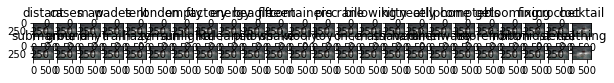

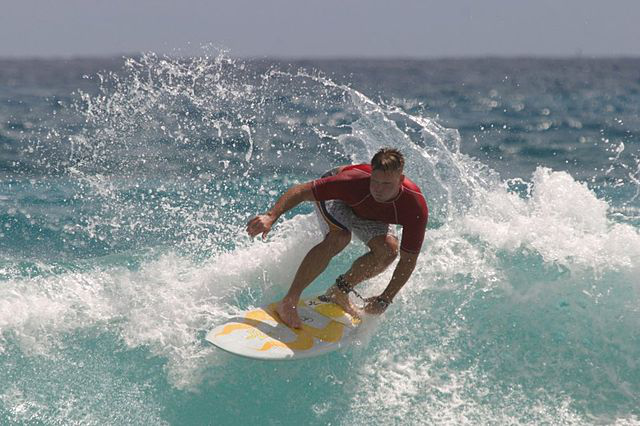

In [22]:
image_url2 = 'https://tensorflow.org/images/surf.jpg'

image_extension = image_url2[-4:]
image_path2 = tf.keras.utils.get_file('image'+image_extension,origin=image_url2)

result, attention_plot,gradients = evaluate(image_path2)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path2, result, attention_plot)
# opening the image
Image.open(image_path2)

In [23]:
encoder.load_weights('captioning/weightsfile.h5')
decoder.load_weights('captioning/weightsfile_Decoder.h5')

In [96]:
image_url2 = 'https://tensorflow.org/images/surf.jpg'

image_extension = image_url2[-4:]
image_path2 = tf.keras.utils.get_file('image'+image_extension,origin=image_url2)
# image_path2 = 'both.png'
# image_path2= 'ILSVRC2012_img_val/ILSVRC2012_val_00000204.JPEG'
loses_gradcam=[]
# result, attention_plot = evaluate(image_path2)

In [97]:


#################
attention_plot = np.zeros((max_length, attention_features_shape))

hidden = decoder.reset_state(batch_size=1)

temp_input = tf.expand_dims(load_image(image_path2)[0], 0)
with tf.GradientTape() as tape1:
    img_tensor_val_cnn = image_features_extract_model(temp_input) # cnn model
    img_tensor_val = tf.reshape(img_tensor_val_cnn, (img_tensor_val_cnn.shape[0], -1, img_tensor_val_cnn.shape[3])) #reshape `

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):

        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        # print(predictions.shape)
        # print(np.argmax(predictions))
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            break

        dec_input = tf.expand_dims([predicted_id], 0)

gradients=tape1.gradient(predictions, img_tensor_val_cnn)


attention_plot = attention_plot[:len(result), :]

#################
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path2, result, attention_plot)
# opening the image

# Image.open(image_path2)

Prediction Caption: a man that is on a white surfboard <end>


Prediction Caption: a man that is on a white surfboard <end>


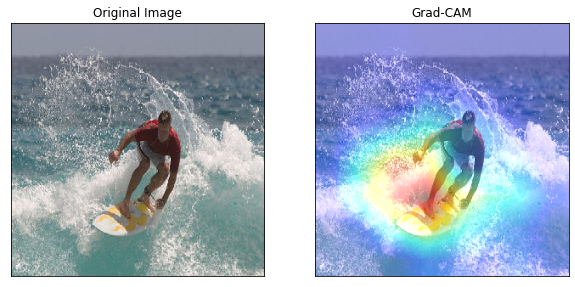

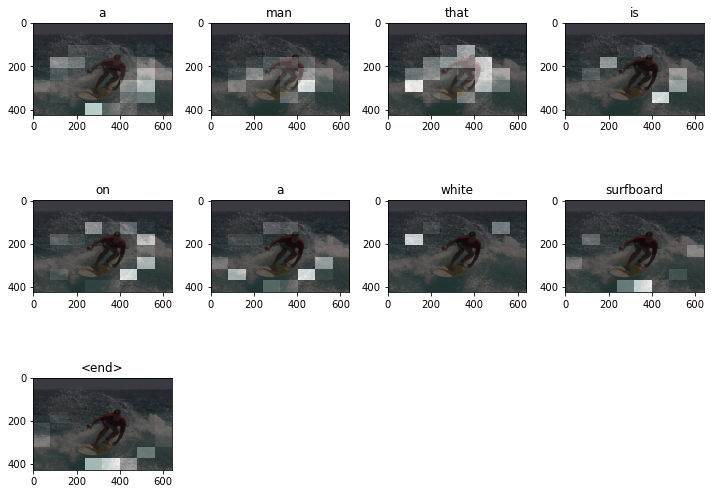

In [98]:
layer_output=img_tensor_val_cnn[0].numpy()

neuron_importance_weights=tf.reduce_mean(gradients, axis=(0, 1, 2)).numpy()
for i in range(neuron_importance_weights.shape[-1]):
    layer_output[:, :, i] *= neuron_importance_weights[i]
gradcam = tf.reduce_mean(layer_output, axis=-1).numpy()



if np.max(gradcam) == 0:
    gradcam = gradcam/(np.max(gradcam)+tf.keras.backend.epsilon())
else:
    gradcam = gradcam/np.max(gradcam)    
gradcam = tf.keras.activations.relu(gradcam)

# img = keras.preprocessing.image.img_to_array(img)
import cv2
heatmap = np.squeeze(gradcam)
heatmap = cv2.resize(heatmap, (299, 299))
# heatmap = -1*heatmap +1
heatmap = np.clip(heatmap, 0., 1.)

orig_img,img=load_test_img(image_path2)

from image_utils import imagenet_utils
heatmap_colormap,overlayed_img=imagenet_utils.overlay_heatmap(orig_img,heatmap)
f, axarr = plt.subplots(1,2)
f = plt.gcf()
f.set_size_inches(10,7)
print ('Prediction Caption:', ' '.join(result))
for ax in axarr:
    ax.set_xticks([])
    ax.set_yticks([])
axarr[0].imshow(orig_img)
axarr[0].title.set_text('Original Image')
axarr[1].imshow(overlayed_img)
axarr[1].title.set_text('Grad-CAM')
plot_attention(image_path2, result, attention_plot)